In [ ]:
pip install ucimlrepo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from ucimlrepo import fetch_ucirepo

In [ ]:
######################################
# ========== DATA LOADING ========== #
######################################
X = infrared_data.data.features
y = infrared_data.data.targets.iloc[:, 0]
selected_features = ["aveAllR13_1", "aveAllL13_1", "T_RC1", "T_RC_Dry1", "T_RC_Wet1", "T_atm"]
X = X[selected_features].apply(pd.to_numeric, errors='coerce').dropna()
y = y.loc[X.index]

# Define temperature thresholds
T1, T2, T3 = 36.4, 36.5, 37

def categorize_temp(temp):
    if temp < T1:
        return "Very Cold"
    elif T1 <= temp < T2:
        return "Cold"
    elif T2 <= temp < T3:
        return "Hot"
    else:
        return "Very Hot"

y = y.apply(categorize_temp)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, "label_encoder.pkl")

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [ ]:
########################################################################
# ========== STEP 2: BUILD TEMPERATURE CLASSIFICATION MODEL ========== #
########################################################################
class TemperatureClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TemperatureClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_dim = len(selected_features)
num_classes = len(label_encoder.classes_)
model = TemperatureClassifier(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(list(zip(X_train_tensor, y_train_tensor)), batch_size=32, shuffle=True)
val_loader = DataLoader(list(zip(X_test_tensor, y_test_tensor)), batch_size=32, shuffle=False)

Epoch [1/20], Train Loss: 1.2080, Val Loss: 1.0716
Epoch [2/20], Train Loss: 0.9505, Val Loss: 0.8282
Epoch [3/20], Train Loss: 0.8054, Val Loss: 0.7310
Epoch [4/20], Train Loss: 0.7520, Val Loss: 0.7060
Epoch [5/20], Train Loss: 0.7463, Val Loss: 0.6899
Epoch [6/20], Train Loss: 0.7337, Val Loss: 0.6843
Epoch [7/20], Train Loss: 0.7224, Val Loss: 0.6807
Epoch [8/20], Train Loss: 0.7166, Val Loss: 0.6739
Epoch [9/20], Train Loss: 0.7112, Val Loss: 0.6690
Epoch [10/20], Train Loss: 0.7066, Val Loss: 0.6678
Epoch [11/20], Train Loss: 0.7085, Val Loss: 0.6653
Epoch [12/20], Train Loss: 0.7074, Val Loss: 0.6652
Epoch [13/20], Train Loss: 0.7084, Val Loss: 0.6630
Epoch [14/20], Train Loss: 0.7012, Val Loss: 0.6643
Epoch [15/20], Train Loss: 0.7006, Val Loss: 0.6595
Epoch [16/20], Train Loss: 0.6935, Val Loss: 0.6607
Epoch [17/20], Train Loss: 0.6985, Val Loss: 0.6588
Epoch [18/20], Train Loss: 0.6962, Val Loss: 0.6582
Epoch [19/20], Train Loss: 0.6972, Val Loss: 0.6561
Epoch [20/20], Train 

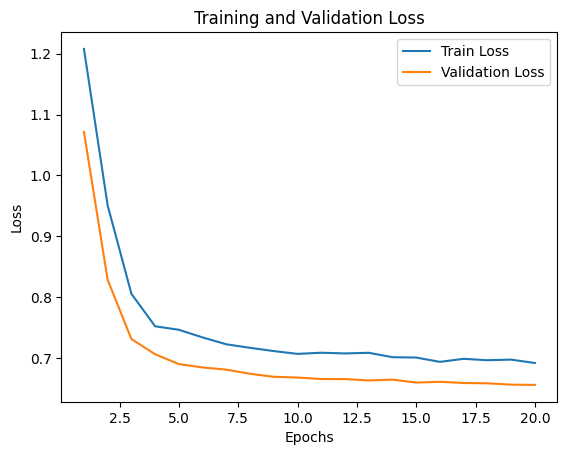

In [ ]:
###############################################
# ========== TRAINING LOOP ========== #
###############################################
num_epochs = 20
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, labels in val_loader:
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

torch.save(model.state_dict(), "temperature_model.pth")

# Plot training and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

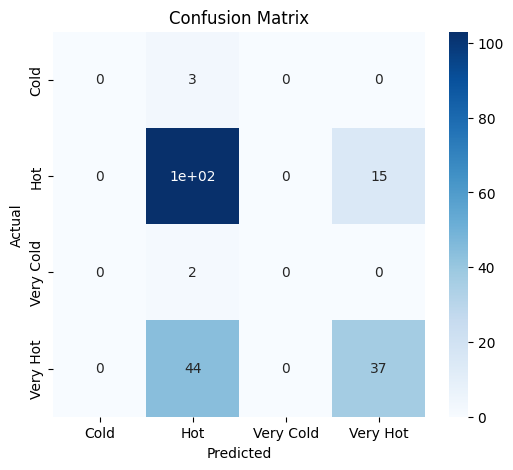

In [ ]:
##########################################
# ========== CONFUSION MATRIX ========== #
##########################################
model.eval()
preds, actuals = [], []
with torch.no_grad():
    for features, labels in val_loader:
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.numpy())
        actuals.extend(labels.numpy())

conf_matrix = confusion_matrix(actuals, preds)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

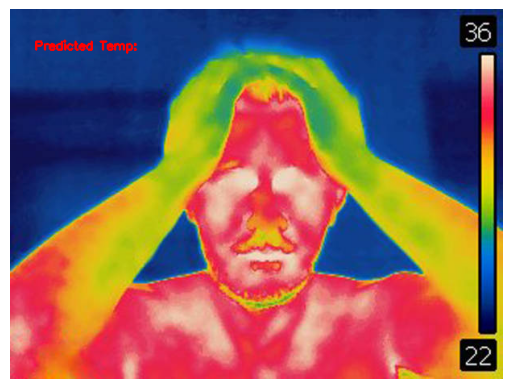

Predicted Temperature Category: Hot


In [ ]:
###########################################################
# ========== PREDICT TEMPERATURE FROM IR IMAGE ========== #
###########################################################

import cv2
import numpy as np
import torch
import joblib
import pandas as pd
import matplotlib.pyplot as plt

def extract_features_from_ir_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))

    # Normalize pixel values to range [0, 1]
    img_normalized = img / 255.0

    # Compute stable statistical features
    ave_temp = np.mean(img_normalized)
    std_temp = np.std(img_normalized)

    # Reduce histogram bins to 4 (to maintain expected feature count)
    hist = cv2.calcHist([img], [0], None, [4], [0, 256])  # 4-bin histogram
    hist = hist.flatten() / np.sum(hist)  # Normalize histogram

    # Construct feature vector
    features = np.concatenate(([ave_temp, std_temp], hist))  # Now has 6 values

    return features

def predict_temperature_from_image(image_path):
    model.load_state_dict(torch.load("temperature_model.pth", weights_only=True))  # Safe loading
    model.eval()
    scaler = joblib.load("scaler.pkl")
    label_encoder = joblib.load("label_encoder.pkl")

    features = extract_features_from_ir_image(image_path)

    # Ensure feature names match what the scaler was trained on
    features_df = pd.DataFrame([features], columns=scaler.feature_names_in_)
    features_scaled = scaler.transform(features_df)

    features_tensor = torch.tensor(features_scaled, dtype=torch.float32)

    with torch.no_grad():
        output = model(features_tensor)
        _, predicted_class = torch.max(output, 1)

    predicted_category = label_encoder.inverse_transform([predicted_class.item()])[0]

    # Load image and overlay temperature text
    img = cv2.imread(image_path)
    cv2.putText(img, f"Predicted Temp: ", (30, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Save and display the image
    cv2.imwrite("output_with_prediction.jpg", img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    return predicted_category

image_path = "ir_1.jpg"
predicted_temp = predict_temperature_from_image(image_path)
print("Predicted Temperature Category:", predicted_temp)
